In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter
import lightgbm as lgb 
import pickle

In [11]:
raw_data = pd.read_pickle("/Users/yiningqu/Desktop/研究生/33160 Machine Learning/Assignment2/dataset.pkl")
data = raw_data[raw_data['market_cap'] > 1000.0]
data.fillna(0.0,inplace=True)

/var/folders/x9/dklkzy9s3rj0cq0ryk2h2zcc0000gn/T/ipykernel_55911/738055641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0.0,inplace=True)


In [12]:
def f(x):

    if x > 0.01:
        return 1
    elif x < -0.01:

        return -1
    

    else:
    
        return 0

In [13]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

/var/folders/x9/dklkzy9s3rj0cq0ryk2h2zcc0000gn/T/ipykernel_55911/4178565263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rel_performance'] = data['pred_rel_return'].apply(f)


In [14]:
df_1 = data.loc['2007-01-01':'2010-01-01']
df_2 = data.loc['2007-04-01':'2010-04-01']
df_valid = data.loc['2010-04-01':'2010-07-01']
df_test = data.loc['2010-07-01':'2010-10-01']

In [15]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
train_2 = df_2.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [16]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
train_2_stock_returns = df_2['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_2 = df_2['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_2 = y_2.values
y_valid = y_valid.values
y_test = y_test.values

In [17]:
gb_clf = lgb.LGBMClassifier(boosting_type='dart',max_depth=4,n_estimators=400,objective='multi_class',min_data_in_leaf=1600,
                            reg_lambda = 0.6,learning_rate=0.2)

In [18]:
gb_clf.fit(train_1,y_1)

[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600


[LightGBM] [Fatal] Number of classes must be 1 for non-multiclass training


LightGBMError: Number of classes must be 1 for non-multiclass training

In [ ]:
Counter(y_1)

In [ ]:
y_valid = y_valid+1

In [ ]:
Counter(y_valid)

In [ ]:
lgb_train = lgb.Dataset(train_1,y_1)
lgb_eval = lgb.Dataset(valid,y_valid)

In [ ]:
params = {
    'device':'cpu',
    'boosting_type': 'gbdt',
    'task':'train',
    'objective': 'multiclass',
    'min_data_in_leaf':2000,
    'max_depth':4,

#     'metric': {'multi_logloss'},
    'num_class':3,

    'num_leaves': 31,

    'learning_rate': 0.1,

    'feature_fraction': 0.5,

    'bagging_fraction': 0.5,

    'bagging_freq': 7,

    'verbose': 0,
    'cegb_penalty_split':0.3

}

In [ ]:
gbm = lgb.train(params,lgb_train,num_boost_round=400)

In [ ]:
gbm.save_model('model.txt')

In [ ]:
gbm.feature_importance()

In [14]:
gb_clf.score(train_1,y_1)

0.6236953280318092

In [16]:
preds = gb_clf.predict(valid)

In [15]:
gb_clf.score(valid,y_valid)

0.5065926439972241

In [17]:
confusion_matrix(y_valid,preds)

array([[138,   0, 451],
       [ 28,   1,  74],
       [158,   0, 591]], dtype=int64)

In [18]:
def gboost_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [19]:
fi = gboost_feat_importances(gb_clf,train_1)

In [20]:
features = fi[(fi['feat_imp'] > 50)]

In [21]:
features.shape

(38, 2)

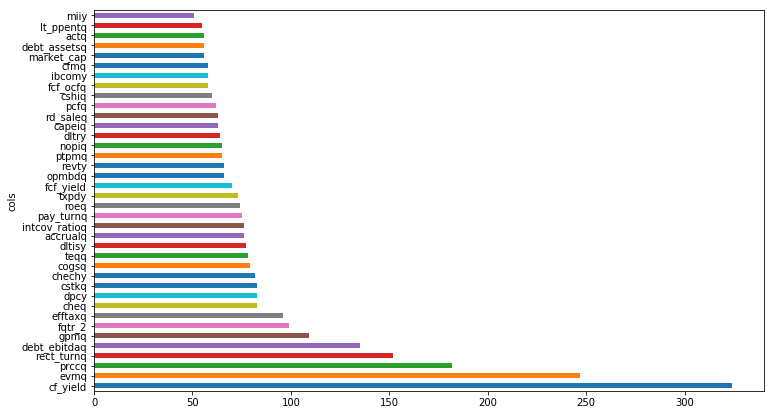

In [22]:
plot_fi(features);

In [73]:
features

,cols,feat_imp
105,cf_yield,324
95,evmq,247
87,prccq,182
171,rect_turnq,152
147,debt_ebitdaq,135
112,gpmq,109
180,fqtr_2,99
120,efftaxq,96
4,cheq,83
71,dpcy,83


In [23]:
train_1 = train_1[features['cols'].values]
valid = valid[features['cols'].values]

In [24]:
gb_clf.fit(train_1,y_1)
gb_clf.score(train_1,y_1)

0.6098409542743539

In [25]:
pred_valid = gb_clf.predict(valid)
gb_clf.score(valid,y_valid)

0.5058986814712005

In [26]:
(pred_valid * valid_stock_returns).sum()

-27.358241000000042

In [27]:
def profit_importance(m,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(10):
            X = df.copy()
            X[col] = np.random.permutation(X[col].values)
            prediction = m.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

In [28]:
def gbboost_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [29]:
pi = gbboost_profit_importance(gb_clf,valid,valid_stock_returns)
pi

,cols,pi_imp
8,cheq,-29.977267
28,pcfq,-29.410358
34,debt_assetsq,-29.135823
13,teqq,-28.836401
31,ibcomy,-28.576050
19,txpdy,-28.530145
36,lt_ppentq,-28.107478
9,dpcy,-28.104756
17,pay_turnq,-28.082493
37,miiy,-27.968928


In [81]:
profits = []
feat=[]

train = train_1.copy()
validation = valid.copy()

while len(train.columns)>1:

    pred_valid = gb_clf.predict(validation)
       
    print((pred_valid * df_valid['next_period_return']).sum())
    profits.append((pred_valid * df_valid['next_period_return']).sum())
    feat.append(train.columns)
    
    col_to_drop = pi.iloc[-1]['cols']
    train.drop(col_to_drop,axis=1,inplace=True)
    validation.drop(col_to_drop,axis=1,inplace=True)

    gb_clf.fit(train,y_1)
    pi = gbboost_profit_importance(gb_clf,validation,df_valid['next_period_return'])

-27.358241000000042
-26.57345700000006
-25.71485700000006
-30.537119000000047
-24.081781000000063
-20.792927000000063
-20.705441000000075
-25.853601000000047
-24.08804500000004
-24.19756500000004
-20.850579000000028
-22.793563000000038
-13.958813000000042
-18.729193000000038
-17.826579000000027
-17.709971000000046
-20.32345700000005
-20.037127000000034
-21.972649000000054
-21.500285000000044
-23.493121000000052
-20.145027000000034
-20.308395000000054
-19.131899000000054
-17.196717000000042
-18.46351100000006
-14.466739000000054
-8.385651000000028
-11.238449000000045
-11.53664900000006
-7.266187000000034
-8.933005000000017
-14.901539000000026
-17.104511000000024
-24.301531000000004
-27.295379000000054
-22.373655000000056


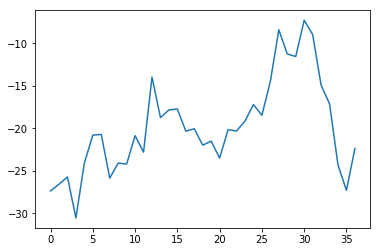

In [82]:
plt.plot(profits);

In [83]:
n = np.argmax(profits)
profits[n]

-7.266187000000034

In [84]:
optim_feats = feat[n]
optim_feats

Index(['cf_yield', 'debt_ebitdaq', 'efftaxq', 'cheq', 'cstkq', 'chechy',
       'fcf_yield', 'cshiq'],
      dtype='object')

In [85]:
train_1_optim = train_1[optim_feats]
valid_optim = valid[optim_feats]


gb_clf.fit(train_1_optim,y_1)
print(gb_clf.score(train_1_optim,y_1))
pred_valid_tree = gb_clf.predict(valid_optim)
print(gb_clf.score(valid_optim,y_valid))
(pred_valid_tree * valid_stock_returns).sum()

0.5579647117296223
0.5281054823039556


-7.266187000000034

In [86]:
train_2_tree = train_2[optim_feats]
test_tree = test[optim_feats]
gb_clf.fit(train_2_tree,y_2)
pred_test_tree = gb_clf.predict(test_tree)
(pred_test_tree * test_stock_returns).sum()

97.59550899999999

In [87]:
from scipy.cluster import hierarchy as hc
import scipy.stats

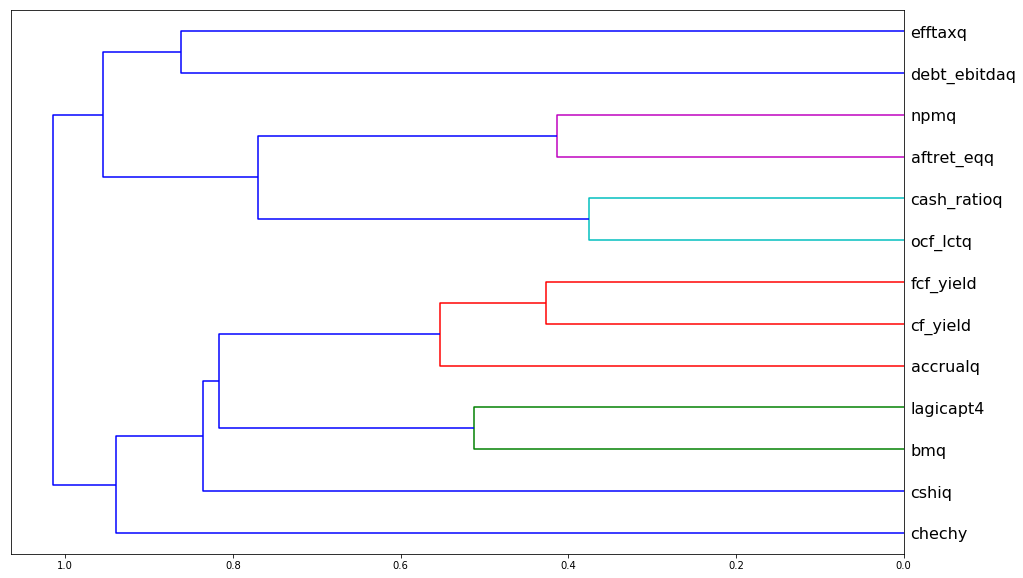

In [36]:
corr = np.round(scipy.stats.spearmanr(train_1_optim).correlation,4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=train_1_optim.columns, orientation='left', leaf_font_size=16)
plt.show()

In [37]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [38]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [39]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [40]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [41]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [88]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [89]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)-1):
        gb_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = gb_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

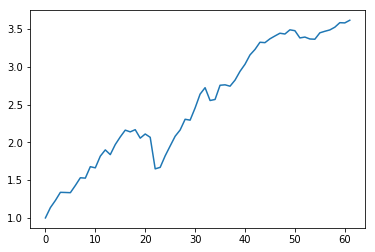

In [90]:
plt.plot(x);

In [91]:
SPY = pd.read_pickle(r'C:\Users\niels\data\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-04-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

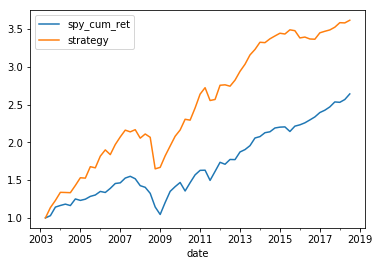

In [92]:
SPY.plot();

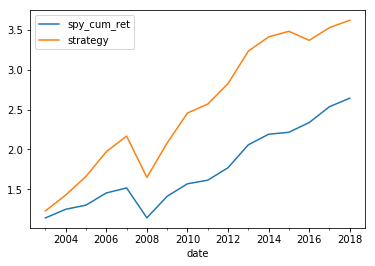

In [93]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [94]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.6782271458019897


In [95]:
x[-1]

3.617185853182566

In [96]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [97]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

1.4619050972527126

In [ ]:
residual_ret = strategy_ret - beta * spy_ret

In [ ]:
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

In [ ]:
alpha = np.mean(residual_ret)
alpha